# Mission n°1
Avant de pouvoir entrer dans le vif du sujet, il vous faudra faire un peu de nettoyage !<br>
Par exemple, vous devrez faire des choix quant au traitement des valeurs manquantes et des valeurs aberrantes.

<a id=tdm></a>
### Table des matières

#### 1. [Table 'transactions'](#trans)
 * [Exclusion des valeurs de test](#trans1)
 * [Identfication des clés](#trans2)
 * [Transformation de 'date' en timestamp](#trans3)
 * [Création de variables de temps](#trans4)
 * [Conclusion](#trans5)
 
#### 2. [Table 'products'](#prod)
 * [Exclusion des valeurs de test](#prod1)<br>
 * [Skewness de 'price'](#prod2) 
 * [Recherche de doublons dans 'id_prod'](#prod3) 
 
#### 3. [Table 'customers'](#cust)
 * [Exclusion des valeurs de test](#cust1)<br>
 * [Recherche de doublons dans 'client_id'](#cust2)<br>
 * [Calcul de l'âge des clients](#cust3)

#### 4. [Merge des 3 tables](#mrg)
 * [Merge de transactions et cutomers (left join)](#mrg1)
 * [Merge avec products (outer joint)](#mrg2)
 * [Identification des NaN dans 'price'](#mrg3) 
 * [Description de la valeur de 'price' pour la catégorie 0](#mrg4) 
 * [Remplacement des NaN de 'price' et 'categ' pour le produit 0_2245](#mrg5) 

 
#### 5. [Contrôle de la cohérence des variables](#ctrl)
 * [Somme de price pour client_id](#ctrl1)
 * [Nombre de sessions mensuelles par catégorie](#ctrl2)
 * [Chiffre d'affaire (CA) mensuel par catégorie](#ctrl3)
 * [Détail sur octobre pour la catégorie 1](#ctrl4)
 * [Dernier contrôle de la table et export](#ctrl5)

In [1]:
# Import des librairies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pylab import rcParams
from scipy import stats
import seaborn as sns
%matplotlib inline

<a id=trans></a>
## 1. [[tdm]](#tdm) Table 'transactions'

In [2]:
# Import des données 'transactions'
trans = pd.read_csv('data/transactions.csv')

<a id=trans1></a>
####  1. [[tdm]](#tdm) Exclusion des valeurs de test 
La variable 'date' contient une série de valeurs contenant le mot 'test'

In [3]:
# Recherche pour 'date' des lignes contenant 'test'
test = trans[trans['date'].str.contains('test')]
test.head(1)

,id_prod,date,session_id,client_id
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1


In [4]:
# nombre de lignes
test['date'].count()

200

In [5]:
# Valeurs uniques de 'id_prod'
test['id_prod'].unique()

array(['T_0'], dtype=object)

In [6]:
# Valeurs uniques de 'session_id'
test['session_id'].unique()

array(['s_0'], dtype=object)

In [7]:
# Valeurs uniques de 'client_id'
test['client_id'].unique()

array(['ct_1', 'ct_0'], dtype=object)

* Il y a 200 valeurs contenant le mot 'test' dans **date** 
 - **id_prod** = T_0
 - **session_id** = s_0
 - **client_id** = ct_0, ct_1
 
* Il faut exclure les valeurs de test pour ne garder que le trafic réel
* On doit garder en mémoire pour les autres fichiers que **id_prod** = T_0 et **client_id** = ct_0, ct_1 sont à exclure

In [8]:
# on retire les lignes de 'date' contenant 'test'
trans2=trans[~trans['date'].str.contains('test')]
trans2 = trans2.reset_index()
trans2.head(0)

,index,id_prod,date,session_id,client_id


<a id=trans2></a>
####  2. [[tdm]](#tdm) Identfication des clés 

![](img/Q1/relations_df.png)

<a id=trans3></a>
#### 3. [[tdm]](#tdm) Transformation de 'date' en timestamp

In [9]:
transactions = trans2.copy()
# On renomme la colonne 'date' en 'timestamp'
transactions = transactions.rename(index=str, columns={'date': 'timestamp'})

# On converti en dates
transactions['timestamp'] = pd.to_datetime(transactions['timestamp'])
transactions.head(1)

,index,id_prod,timestamp,session_id,client_id
0,0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450


<a id=trans4></a>
#### 4. [[tdm]](#tdm) Création de variables de temps

In [10]:
# création de la colonne timelime = 'year + month'
transactions['timeline'] = transactions['timestamp'].dt.strftime('%Y-%m')

# création de la colonne 'date'
transactions['date'] = transactions['timestamp'].dt.strftime('%d-%m-%Y')

# création de la colonne 'year'
transactions['year'] = transactions['timestamp'].dt.year

# création de la colonne 'month'
transactions['month'] = transactions['timestamp'].dt.month

# création de la colonne 'day'
transactions['day'] = transactions['timestamp'].dt.weekday_name
transactions.head(1)

# # création de la colonne 'hour'
transactions['hour'] = transactions['timestamp'].dt.hour

# Tri par ordre croissant sur 'timelime'
transactions.sort_values(['timeline'], ascending=[True], inplace=True)
transactions.head(1)

,index,id_prod,timestamp,session_id,client_id,timeline,date,year,month,day,hour
51887,51907,1_264,2021-03-28 17:16:26.325707,s_12716,c_6624,2021-03,28-03-2021,2021,3,Sunday,17


In [11]:
# check unique 'timeline'
transactions['timeline'].unique()

array(['2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08',
       '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02'],
      dtype=object)

<a id=trans5></a>
#### 5. [[tdm]](#tdm) Conclusion

**Nous avons :**
* 12 mois d'activité de mars 2021 à février 2022 pour 'timeline'
* 2 valeurs pour 'year'
* 365 valeurs pour 'date'
* 12 valeurs pour 'month'
* 31 valeurs pour 'day'
* 24 valeurs pour 'hour'

<a id=prod></a>
## 2. [[tdm]](#tdm) Table 'products'

In [12]:
# Import des données 'products'
prod = pd.read_csv('data/products.csv')

<a id=prod1></a>
#### 1. [[tdm]](#tdm) Exclusion des valeurs de test

In [13]:
# exclusion du test 'T_0' dans 'id_prod'
prod = prod[~prod['id_prod'].str.contains('T_0')]
prod.head(2)

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0


In [14]:
# comportement des valeurs de 'price'
prod['price'].describe()

count    3286.000000
mean       21.863597
std        29.849786
min         0.620000
25%         6.990000
50%        13.075000
75%        22.990000
max       300.000000
Name: price, dtype: float64

* Le prix d'un article est compris entre 0.62 et 300.00 
* Il y a un grand écart entre le 3e quartile et le max
* La moyenne est plus proche du 3e quartile que de la médiane, laissant supposer un skewness à droite

<a id=prod2></a>
#### 2. [[tdm]](#tdm) Skewness du prix des produits

C:\Users\Lolo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


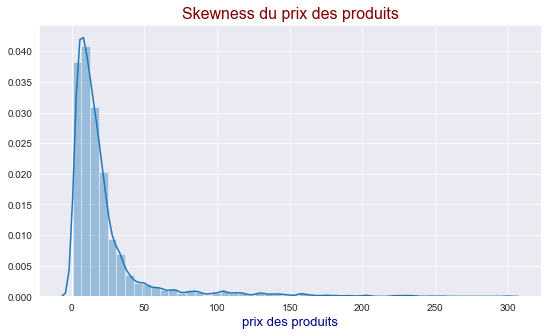

In [15]:
skew = prod[['price']]

# visualisation du skewness de 'price'
sns.set_style("darkgrid")
plt.figure(figsize=(9,5))

# graphique
sns.distplot(skew.price)

plt.title('Skewness du prix des produits', fontsize=16, color='maroon')
# labels
plt.xlabel('prix des produits', color='darkblue', size=13)


plt.savefig('img/Q1/2.2 skewness.png', dpi=120, bbox_inches='tight')
plt.show()
plt.close()

* Le skewness à droite est très étendu mais les valeurs sont contentrées entre la médiane et le 3e quartile

In [16]:
#check des valeurs de 'categ'
prod['categ'].unique()#check de Flag Description

array([0, 1, 2], dtype=int64)

* Il n'y a que 3 catégories de produits

<a id=prod3></a>
#### 3. [[tdm]](#tdm) Recherche de doublons dans 'id_prod'

In [17]:
a = prod['id_prod']
b = set(prod['id_prod']) #supprime les doublons...

if len(a) != len(b):
    print('doublons dans id_prod')
else:
    print( 'pas de doublons dans id_prod')

pas de doublons dans id_prod


<a id=cust></a>
## 3. [[tdm]](#tdm)  Table 'customers'

In [18]:
# Import des données 'customers'
cust = pd.read_csv('data/customers.csv')
cust.head(1)

,client_id,sex,birth
0,c_4410,f,1967


<a id=cust1></a>
#### 1. [[tdm]](#tdm) Exclusion des valeurs de test

In [19]:
# supression des 2 clients-tests
cust = cust[~cust['client_id'].isin(['ct_0', 'ct_1'])]
cust.head(1)

,client_id,sex,birth
0,c_4410,f,1967


<a id=cust2></a>
#### 2. [[tdm]](#tdm) Recherche de doublons dans 'client_id'

In [20]:
a = cust['client_id']
b = set(cust['client_id']) #supprime les doublons...

if len(a) != len(b):
    print('doublons dans client_id')
else:
    print( 'pas de doublons dans client_id')

pas de doublons dans client_id


<a id=cust3></a>
#### 3. [[tdm]](#tdm) Calcul de l'âge des clients
* On suppose que l'action se déroule début mars 2022, les dernières valeurs recueillies datant de février 2022

In [21]:
# Calcul de l'âge des clients basé sur l'année de naissance
cust['age'] = 2022 - cust['birth']

# supression de la variable 'birth'
cust.drop(['birth'], axis=1, inplace = True)
cust.head(1)

,client_id,sex,age
0,c_4410,f,55


In [22]:
# comportement des valeurs
cust['age'].describe()

count    8621.000000
mean       43.724394
std        16.917958
min        18.000000
25%        30.000000
50%        43.000000
75%        56.000000
max        93.000000
Name: age, dtype: float64

* La moyenne et la médiane sont quasi identiques, aux alentours de 43 ans
* Pas d'âge aberrant a priori, nous sommes sensés être en mars 2022 (dernier mois de data = 02/2022)
* Le plus vieux client aurait 93 ans et le plus jeune 18 ans
* Cependant ne disposant ni du mois ni du jour de naissance, considérons 'age' comme un intervalle

In [23]:
# valeurs uniques dans 'sex'
cust['sex'].unique()

array(['f', 'm'], dtype=object)

<a id=mrg></a>
## 4. [[tdm]](#tdm) Merge des 3 tables

In [24]:
# rappel des données 'transactions'
temp = transactions.copy()
temp.head(1)

,index,id_prod,timestamp,session_id,client_id,timeline,date,year,month,day,hour
51887,51907,1_264,2021-03-28 17:16:26.325707,s_12716,c_6624,2021-03,28-03-2021,2021,3,Sunday,17


In [25]:
# rappel des données 'products'
prod.head(1)

,id_prod,price,categ
0,0_1421,19.99,0


In [26]:
# rappel des données 'customers'
cust.head(1)

,client_id,sex,age
0,c_4410,f,55


<a id=mrg1></a>
####  1. [[tdm]](#tdm)  Merge de transactions et cutomers (left join)
* Nous utilisons un left join (transactions) car notre mission est d'analyser les ventes

In [27]:
# left join de 'temp' et de 'cust' sur la clé 'client_id'
tab = pd.merge(temp, cust, on='client_id', how='left')
tab = tab.reset_index()
tab.head(1)

,level_0,index,id_prod,timestamp,session_id,client_id,timeline,date,year,month,day,hour,sex,age
0,0,51907,1_264,2021-03-28 17:16:26.325707,s_12716,c_6624,2021-03,28-03-2021,2021,3,Sunday,17,m,69


<a id=mrg2></a>
#### 2. [[tdm]](#tdm) Merge de products (outer joint)
* Nous utilisons outer join pour contrôler l'ensemble des valeurs

In [28]:
# outer join de 'tab' et de 'p`rod' sur la clé 'client_id'
table = pd.merge(tab, prod, on='id_prod', how='outer')
table.head(1)

,level_0,index,id_prod,timestamp,session_id,client_id,timeline,date,year,month,day,hour,sex,age,price,categ
0,0.0,51907.0,1_264,2021-03-28 17:16:26.325707,s_12716,c_6624,2021-03,28-03-2021,2021.0,3.0,Sunday,17.0,m,69.0,16.07,1.0


In [29]:
# réorganisation des colonnes
table = table[['session_id','client_id','sex','age','id_prod','price','categ','timeline',
             'date','year','month','day','hour','timestamp']]
table.head(1)

,session_id,client_id,sex,age,id_prod,price,categ,timeline,date,year,month,day,hour,timestamp
0,s_12716,c_6624,m,69.0,1_264,16.07,1.0,2021-03,28-03-2021,2021.0,3.0,Sunday,17.0,2021-03-28 17:16:26.325707


<a id=mrg3></a>
#### 3. [[tdm]](#tdm) Identification des NaN

In [30]:
# rappel de la table
nan = table[['session_id','client_id','id_prod','categ','price']].copy()

In [31]:
# NaN dans session_id
nan = nan.loc[nan['session_id'].isnull()] 
nan.head(2)

,session_id,client_id,id_prod,categ,price
336816,NaN,NaN,0_1016,0.0,35.06
336817,NaN,NaN,0_1780,0.0,1.67


In [32]:
nan.count()

session_id     0
client_id      0
id_prod       22
categ         22
price         22
dtype: int64

* Nous avons 22 clients sans **session_id** ni **ip_prod**
* Sans identifiant **session_id** nous ne pouvons pas observer de transaction
* Nous excluerons ces 22 clients de la table

In [33]:
# on retire les NaN de 'session_id'
table = table[table['session_id'].notnull()].reset_index()

In [34]:
# recherche des NaN sur 'price'
nan2 = table[['session_id','client_id','id_prod','categ','price']].copy()
nan2 = nan2.loc[nan2['price'].isnull()] 
nan2.head(2)

,session_id,client_id,id_prod,categ,price
313915,s_12567,c_966,0_2245,NaN,NaN
313916,s_12938,c_1025,0_2245,NaN,NaN


In [35]:
nan2.count()

session_id    103
client_id     103
id_prod       103
categ           0
price           0
dtype: int64

* Le Nan est provoqué par le **produit 0_2245** qui n'a ni catégorie, ni prix
* La nomenclature de 'id_prod' nous permet de dire que **id_product = '0_xxxx'** indique la **catégorie = '0'**
* On peut remplacer le NaN du prix du **produit 0_2245** par la moyenne ou la médiane des prix de la catégorie '0'

<a id=mrg4></a>
#### 4. [[tdm]](#tdm) Description de la valeur de 'price' pour la catégorie 0

In [36]:
ave_0 = table[['id_prod','price','categ']].copy()

# exclusion de '0_2245' et sélection de la catégorie 0
ave_0 = ave_0[(ave_0['id_prod'] != '0_2245')]
ave_0 = ave_0[(ave_0['categ'] == 0)]

# comportement des valeurs
ave_0['price'].describe()

count    209426.000000
mean         10.646828
std           4.930030
min           0.620000
25%           6.300000
50%           9.990000
75%          14.450000
max          40.990000
Name: price, dtype: float64

* La moyenne (10.64) et la médiane (9.99) sont proches
* Je fais le choix de la **médiane** pour remplacer les valeurs manquantes du produit 0_2245 : categ 0 = 9.99

<a id=mrg5></a>
#### 5. [[tdm]](#tdm) Remplacement des NaN de 'price' et 'categ' pour le produit 0_2245

In [37]:
check = table[(table['id_prod'] == '0_2245')]
check['id_prod'].count()

103

In [38]:
# remplacement de NaN par 0 dans 'categ'
table['categ']=table['categ'].fillna('0')
# remplacement de NaN par la médiane dans 'price'
table['price']=table['price'].fillna(9.99)

In [39]:
# contrôle: CA pour le produit 0_2245
describe = table[['session_id','client_id','id_prod','categ','price']].copy()
describe = describe[(describe['id_prod'] == '0_2245')]
round(describe['price'].sum(),2)

1028.97

In [40]:
# contrôle: CA pour le produit 0_2245
table_ct = table[['session_id','client_id','id_prod','categ','price']].copy()
round(table_ct['price'].sum(),2)

5797606.74

In [41]:
# pourcentage du CA de 0_2245 sur total CA
round(1028.97/5797606.74 * 100,3)

0.018

**Conclusion**
* L'impact du remplacement des valeurs manquantes sur le CA total est négligeable
* L'opération aurait pu être négligée et les NaN suprimés
* Toutefois, dans le cadre de l'exercice, il semble important de démontrer notre capacité à réaliser ce genre d'opération

<a id=ctrl></a>
## 5. [[tdm]](#tdm) Contrôle de la cohérence des variables

<a id=ctr1></a>
#### 1. [[tdm]](#tdm) Somme de price pour client_id

In [42]:
pr2= table[['client_id','id_prod','categ','price']].copy()
pr2.head(1)

,client_id,id_prod,categ,price
0,c_6624,1_264,1,16.07


In [43]:
# groupby 'client_id' et calcul de la somme de 'price'
pr2 = pr2.groupby(['client_id']).sum()[['price']]

# On renomme 'price'
pr2.rename(columns={'price': 'tot_achats'}, inplace=True)
pr2 = pr2.reset_index()
pr2.head(1)

,client_id,tot_achats
0,c_1,300.65


In [44]:
# comportement de la variable 'tot_achat'
pr2['tot_achats'].describe()

count      8600.000000
mean        674.140319
std        2565.979402
min           4.150000
25%         275.765000
50%         501.310000
75%         870.897500
max      162007.340000
Name: tot_achats, dtype: float64

* Il y a un max très élogné du 3e quartile
* il y a certainement des valeurs aberrantes

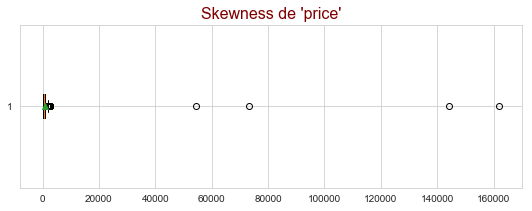

In [45]:
# création du boxplot
sns.set_style("whitegrid")
plt.figure(figsize=(9,3))

plt.boxplot(pr2['tot_achats'],showmeans =True,vert=False )
plt.title("Skewness de 'price'", fontsize=16, color='maroon')

plt.savefig('img/Q1/5.1 skewness_price.png', dpi=120, bbox_inches='tight')
plt.show()
plt.close()

* Nous avons 4 mesures avec des valeurs extrêmes
* Il pourrait s'agir de clients institutionnels (bibliothèques, universités, recherche) 
* Mais cela peut fausser le résultat si l'on étudie l'individu lambda

In [46]:
# exclusion des 4 top clients
pr2 = pr2[~(pr2['client_id'].isin(['c_1609','c_4958','c_6714','c_3454']))]
pr2['tot_achats'].describe()

count    8596.000000
mean      623.971844
std       457.131506
min         4.150000
25%       275.632500
50%       501.170000
75%       869.897500
max      2564.250000
Name: tot_achats, dtype: float64

* La moyenne se rapproche significativement de la médiane
* La standard deviation (dispertion) a été divisée par 5,6

In [47]:
pr3=pr2.copy()
pr3.head(1)

,client_id,tot_achats
0,c_1,300.65


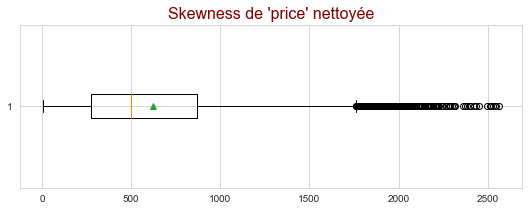

In [48]:
# boxplot sans les top 4 clients
sns.set_style("whitegrid")
plt.figure(figsize=(9,3))

plt.title("Skewness de 'price' nettoyée", fontsize=16, color='maroon')
plt.boxplot(pr3['tot_achats'],showmeans =True,vert=False )

plt.savefig('img/Q1/5.1 skewness_price_nettoyee.png', dpi=120, bbox_inches='tight')
plt.show()
plt.close()

* Matplotlib propose toutefois des outliers, approximativement entre 1750 et 2600

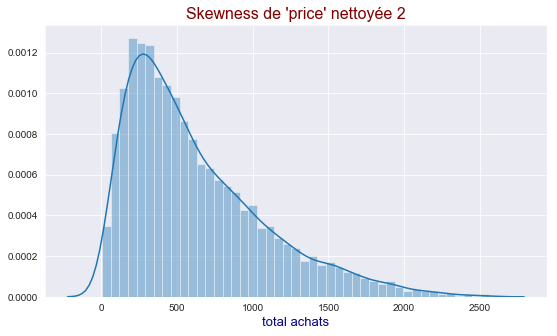

In [49]:
tot_achats = pr3[['tot_achats']]

# visualisation du skewness de 'price'
sns.set_style("darkgrid")
plt.figure(figsize=(9,5))

# graphique
sns.distplot(tot_achats.tot_achats)
# titre
plt.title("Skewness de 'price' nettoyée 2", fontsize=16, color='maroon')
# labels
plt.xlabel('total achats', color='darkblue', size=13)

plt.savefig('img/Q1/5.1 skewness_price_nettoyee_2.png', dpi=120, bbox_inches='tight')
plt.show()
plt.close()

* A la vue de ce graphique, pas d'outliers
* La courbe a simplement un skewness à droite

<a id=ctrl2></a>
#### 2. [[tdm]](#tdm) Nombre de sessions mensuelles par catégorie

In [50]:
# rappel de la table et exclusion des 4 top clients
table = table[~(table['client_id'].isin(['c_1609','c_4958','c_6714','c_3454']))].reset_index()
table.head(1)

,level_0,index,session_id,client_id,sex,age,id_prod,price,categ,timeline,date,year,month,day,hour,timestamp
0,0,0,s_12716,c_6624,m,69.0,1_264,16.07,1,2021-03,28-03-2021,2021.0,3.0,Sunday,17.0,2021-03-28 17:16:26.325707


In [51]:
# groupby et compte de cession_id
timeline = table[['timeline','session_id','categ']].copy()
timeline = timeline.groupby(['timeline','categ']).session_id.count()
timeline = timeline.reset_index()
timeline['categ'] = timeline['categ'].astype('int64', copy=False)
timeline.head(2)

,timeline,categ,session_id
0,2021-03,0,16896
1,2021-03,1,8542


In [52]:
timeline['categ'].unique()

array([0, 1, 2], dtype=int64)

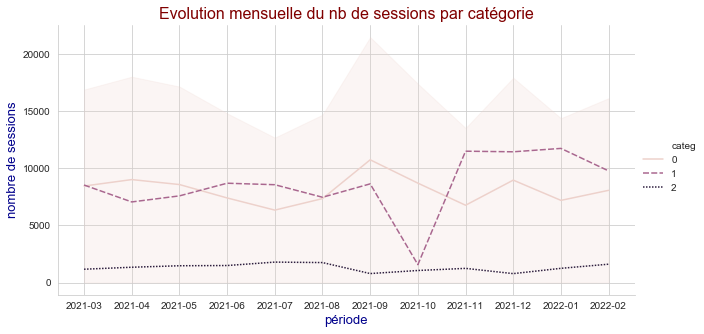

In [53]:
sns.set_style("whitegrid")

sns.relplot(x='timeline', y='session_id', hue='categ', style='categ',height=4.5, aspect=2,
            kind='line', data=timeline)

plt.title("Evolution mensuelle du nb de sessions par catégorie", fontsize=16, color='maroon')
# labels
plt.xlabel('période', color='darkblue', size=13)
plt.ylabel("nombre de sessions", color='darkblue', size=13)

plt.savefig('img/Q1/5.2 CA_cat.png', dpi=120, bbox_inches='tight')
plt.show()
plt.close()

* il y a un effondrement des cessions pour la catégorie 2 sur octobre

<a id=ctrl3></a>
#### 3. [[tdm]](#tdm) Chiffre d'affaire (CA) mensuel par catégorie

In [54]:
# groupby et compte de cession_id
ventes = table[['timeline','categ','price']].copy()
ventes = ventes.groupby(['timeline','categ']).price.sum()
ventes = ventes.reset_index()
ventes['categ'] = ventes['categ'].astype('int64', copy=False)
# on renomme 'price' en 'CA'
ventes.columns = ['timeline','categ','CA']
ventes.head(2)

,timeline,categ,CA
0,2021-03,0,180578.15
1,2021-03,1,174569.68


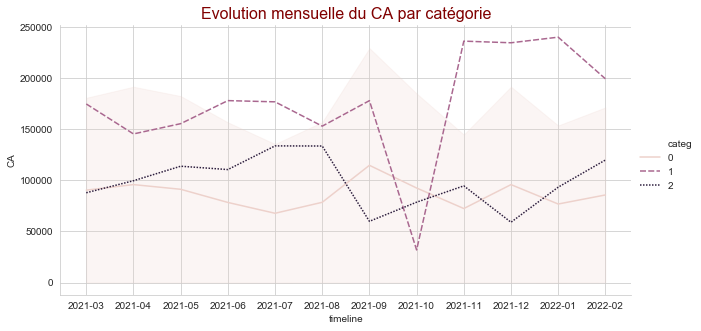

In [55]:
# série temporelle montant des achats par catégorie
sns.set_style("whitegrid")
sns.relplot(x="timeline", y="CA", hue="categ", style="categ",height=4.5, aspect=2,
            kind="line", data=ventes)

plt.title("Evolution mensuelle du CA par catégorie", fontsize=16, color='maroon')

plt.savefig('img/Q1/5.3 nb_achats.png', dpi=120, bbox_inches='tight')

plt.show()
plt.close()

* Il y a un effondrement du CA sur octobre pour la catégorie 1

<a id=ctrl4></a>
#### 4. [[tdm]](#tdm) Détail sur octobre pour la catégorie 1

In [56]:
# rappele de la table
detail = table.copy()
detail.head(1)

,level_0,index,session_id,client_id,sex,age,id_prod,price,categ,timeline,date,year,month,day,hour,timestamp
0,0,0,s_12716,c_6624,m,69.0,1_264,16.07,1,2021-03,28-03-2021,2021.0,3.0,Sunday,17.0,2021-03-28 17:16:26.325707


In [57]:
# sélection des mois désirés (ici juste oct, mais on peut changer l'écart)
detail = detail[detail['month'].between(10, 10, inclusive=True)]

# on sélectionne '1' dans la variable 'categ'
detail = detail[(detail['categ'] == 1)]

#check 'month'
detail['month'].unique()

array([10.])

In [58]:
# groupby et compte de session_id
detail_gp = detail.copy()
detail_gp = detail_gp.groupby(['date']).session_id.count() 
detail_gp = detail_gp.reset_index()
detail_gp.head

<bound method NDFrame.head of          date  session_id
0  01-10-2021         320
1  28-10-2021         298
2  29-10-2021         306
3  30-10-2021         319
4  31-10-2021         328>

* Il n'y a pas de valeurs entre le **2 et le 27 octobre inclus** pour la catégorie 1
* Ce peut être un problème technique (peu probable durant 25 jours) ou une rupture d'approvisionnement (plus probable)
* Il faut choisir si on laisse le dataset en l'état, si l'on retire tout le mois d'octobre ou si l'on remplace les valeurs manquantes
* Je ne suis pas favorable à la supression du mois d'octobre, nous perdons des valeurs pour les catégories 0 et 2
* Attention, nous ne pouvons pas décider maintenant si l'on remplace les valeurs de la catégorie 1 : en supposant que l'on remplace les valeurs de CA par la médiane ou la moyenne, quelles valeurs allons-nous donner pour les variables âge, sex, session_id, client_id, id_prod ?

<a id=ctrl5></a>
#### 5. [[tdm]](#tdm) Dernier contrôle de la table et export

In [59]:
table.head(1)

,level_0,index,session_id,client_id,sex,age,id_prod,price,categ,timeline,date,year,month,day,hour,timestamp
0,0,0,s_12716,c_6624,m,69.0,1_264,16.07,1,2021-03,28-03-2021,2021.0,3.0,Sunday,17.0,2021-03-28 17:16:26.325707


In [60]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313651 entries, 0 to 313650
Data columns (total 16 columns):
level_0       313651 non-null int64
index         313651 non-null int64
session_id    313651 non-null object
client_id     313651 non-null object
sex           313651 non-null object
age           313651 non-null float64
id_prod       313651 non-null object
price         313651 non-null float64
categ         313651 non-null object
timeline      313651 non-null object
date          313651 non-null object
year          313651 non-null float64
month         313651 non-null float64
day           313651 non-null object
hour          313651 non-null float64
timestamp     313651 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(2), object(8)
memory usage: 38.3+ MB


In [61]:
# transformation de plusieurs variables en integer
table['categ'] = table['categ'].astype('int64', copy=False)
table['year'] = table['year'].astype('int64', copy=False)
table['month'] = table['month'].astype('int64', copy=False)
table['hour'] = table['hour'].astype('int64', copy=False)

In [62]:
table.head(1)

,level_0,index,session_id,client_id,sex,age,id_prod,price,categ,timeline,date,year,month,day,hour,timestamp
0,0,0,s_12716,c_6624,m,69.0,1_264,16.07,1,2021-03,28-03-2021,2021,3,Sunday,17,2021-03-28 17:16:26.325707


In [63]:
# Export au format .csv 
table.to_csv('data/table_clean.csv', index = False)